In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , confusion_matrix , classification_report
from sklearn.model_selection import GridSearchCV, cross_validate

In [2]:
df = pd.read_excel('E Commerce Dataset.xlsx', sheet_name='E Comm')
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [3]:
# Data preprocessing
#As mobile phone and phone are both same so we have merged them
df.loc[df['PreferredLoginDevice'] == 'Phone', 'PreferredLoginDevice' ] = 'Mobile Phone'
df.loc[df['PreferedOrderCat'] == 'Mobile', 'PreferedOrderCat' ] = 'Mobile Phone'

#as cod is also cash on delievery
#as cc is also credit card so i merged them
df.loc[df['PreferredPaymentMode'] == 'COD', 'PreferredPaymentMode' ] = 'Cash on Delivery'   # uses loc function
df.loc[df['PreferredPaymentMode'] == 'CC', 'PreferredPaymentMode' ] = 'Credit Card'

# convert num_cols to categories
df2 = df.copy()
for col in df2.columns:
  if col == 'CustomerID':
    continue

  else:
    if df2[col].dtype == 'int':
      df2[col] = df[col].astype(str)

print("Duplicated values are: ", df.duplicated().sum())
print("Null values are: ", df.isnull().sum())
print("Unique values are: ", df.nunique())

# Data cleaning
round((df.isnull().sum()*100 / df.shape[0]),2)

# All Missing values less than 6% so we can impute them
# impute with bfill Method
df['Tenure'] = df['Tenure'].fillna(method = 'bfill')

from sklearn.impute import SimpleImputer
s_imp = SimpleImputer(missing_values=np.nan , strategy = 'most_frequent')
df['WarehouseToHome'] = s_imp.fit_transform(pd.DataFrame(df['WarehouseToHome']))
fill_list = df['HourSpendOnApp'].dropna()
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(pd.Series(np.random.choice(fill_list , size = len(df['HourSpendOnApp'].index))))
# impute with ffill method
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(method = 'ffill')
# Impute with KNN Imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df['CouponUsed']=imputer.fit_transform(df[['CouponUsed']])
# Impute with KNN imputer
imputer_2 = KNNImputer(n_neighbors=2)
df['OrderCount']=imputer_2.fit_transform(df[['OrderCount']])
# impute with bfill Method
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(method = 'bfill')
# After we Checked the data the Customer ID Column not important for our Models so We drop it
df.drop('CustomerID' , axis = 1 , inplace = True)


Duplicated values are:  0
Null values are:  CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64
Unique values are:  CustomerID                     5630
Churn                             2
Tenure                           36
PreferredLoginDevice              2
CityTier                          3
WarehouseToHome                  34
Preferr

C:\Users\USER\AppData\Local\Temp\ipykernel_15908\4288103046.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Tenure'] = df['Tenure'].fillna(method = 'bfill')
C:\Users\USER\AppData\Local\Temp\ipykernel_15908\4288103046.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(method = 'ffill')
C:\Users\USER\AppData\Local\Temp\ipykernel_15908\4288103046.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(method = 'bfill')


In [4]:
# Encoding 
le = LabelEncoder()
# Encode for cat_cols
for i in df.columns:
  if df[i].dtype == 'object':
    df[i] = le.fit_transform(df[i])

C:\Users\USER\AppData\Local\Temp\ipykernel_15908\1998088936.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = churn_corr_vector , y = churn_corr_vector.index , palette = 'coolwarm')


Text(0.5, 1.0, 'Relation Between Features and target')

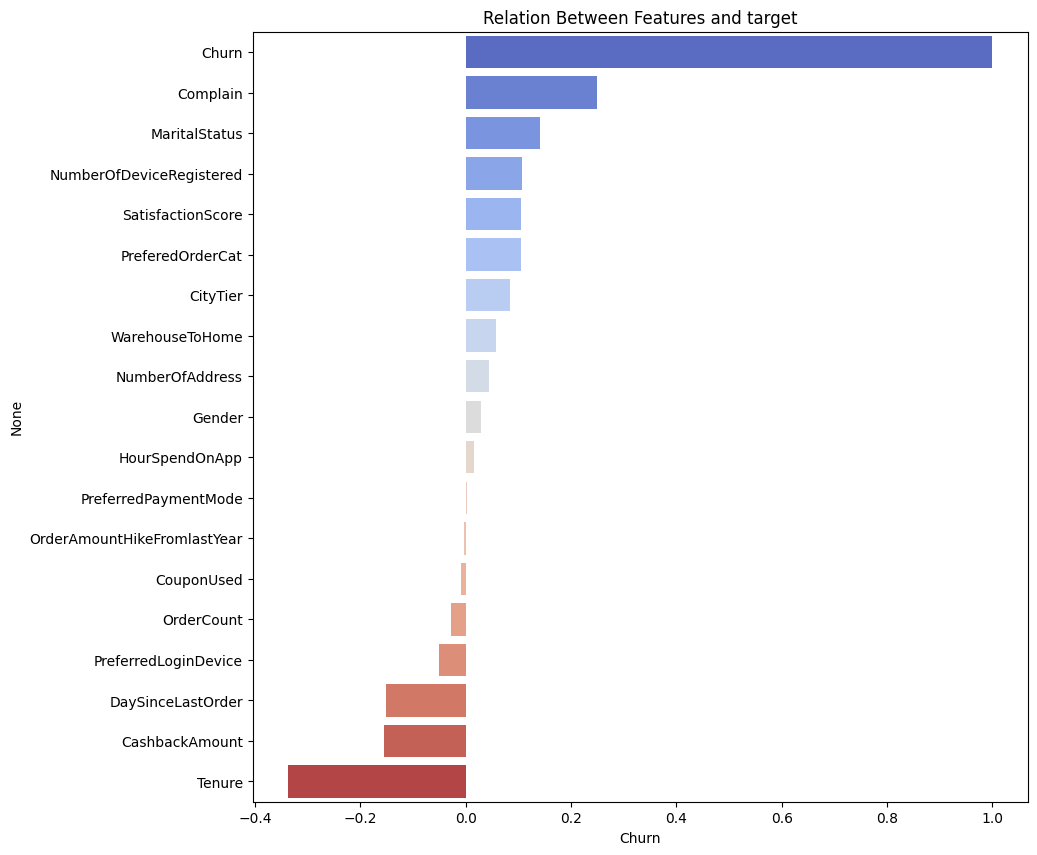

In [5]:
# Visualize relation between features
corr_matrix = df.corr()
churn_corr_vector = corr_matrix['Churn'].sort_values(ascending = False)
plt.figure(figsize = (10,10))
sns.barplot(x = churn_corr_vector , y = churn_corr_vector.index , palette = 'coolwarm')
plt.title('Relation Between Features and target')

In [6]:
# Handle imbalanced data 
X = df.drop('Churn' , axis = 1)
Y = df['Churn']
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
x_over , y_over = smt.fit_resample(X , Y)
print(x_over.shape, y_over.shape)

(9364, 18) (9364,)


In [7]:
#Split data 
x_train , x_test , y_train , y_test = train_test_split(x_over , y_over , test_size = 0.30 , random_state = 42)
# Now we  will make normalization for all data to make them in commom range
from sklearn.preprocessing import MinMaxScaler , StandardScaler , RobustScaler

MN = MinMaxScaler()
# SC = StandardScaler()
# Rb = RobustScaler()
x_train_scaled = MN.fit_transform(x_train)
x_test_scaled = MN.fit_transform(x_test)

In [8]:
# Modeling
import warnings
warnings.filterwarnings("ignore")

XGBoost_Classifier = XGBClassifier()
XGBoost_Classifier.fit(x_train_scaled,y_train)

train_acc_list = []
test_acc_list = []
y_pred_train = XGBoost_Classifier.predict(x_train_scaled)
y_pred_test = XGBoost_Classifier.predict(x_test_scaled)
print(f'Using model XGBClassifier')
print(f'Trainning Score: {XGBoost_Classifier.score(x_train_scaled, y_train)}')
print(f'Test Score: {XGBoost_Classifier.score(x_test_scaled, y_test)}')
print(f'Acc Train: {accuracy_score(y_train, y_pred_train)}')
print(f'Acc Test: {accuracy_score(y_test, y_pred_test)}')
train_acc_list.append(accuracy_score(y_train, y_pred_train))
test_acc_list.append(accuracy_score(y_test, y_pred_test))

Using model XGBClassifier
Trainning Score: 1.0
Test Score: 0.8451957295373665
Acc Train: 1.0
Acc Test: 0.8451957295373665


In [9]:
# Check accuracy training
all_models = pd.DataFrame({'Train_Accuarcy': train_acc_list , 'Test_Accuarcy' : test_acc_list})
all_models

,Train_Accuarcy,Test_Accuarcy
0,1.0,0.845196


Accuracy = 0.8451957295373665
ROC Area under Curve = 0.8448266953190184
              precision    recall  f1-score   support

           0    0.96532   0.71520   0.82165      1401
           1    0.77483   0.97445   0.86325      1409

    accuracy                        0.84520      2810
   macro avg    0.87007   0.84483   0.84245      2810
weighted avg    0.86980   0.84520   0.84251      2810



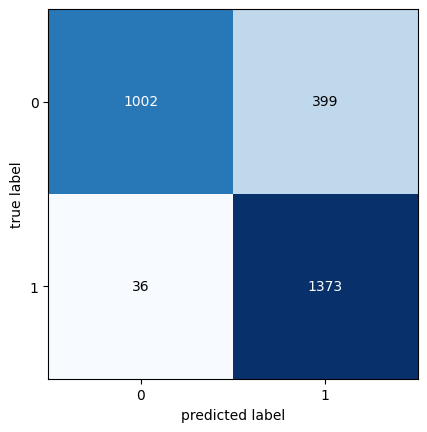

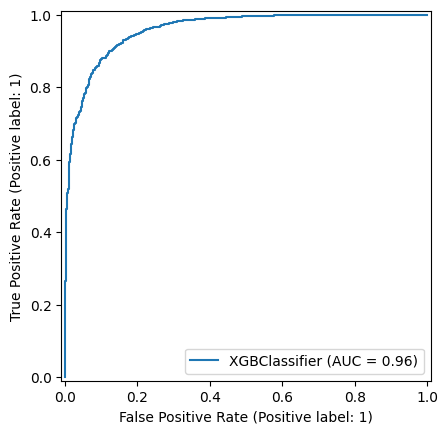

In [10]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, RocCurveDisplay

# Evaluate model
model=XGBClassifier()
model.fit(x_train_scaled,y_train)
y_pred = model.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
roc_auc5 = roc_auc_score(y_test, y_pred)
print("Accuracy = {}".format(accuracy))
print("ROC Area under Curve = {}".format(roc_auc5))
print(classification_report(y_test,y_pred,digits=5))
plot_confusion_matrix(confusion_matrix(y_test , y_pred))
RocCurveDisplay.from_estimator(model , x_test_scaled , y_test)

In [ ]:
# Laucnh MLFlow server command 
# mlflow server --host 127.0.0.1 --port 8080

Do this only if no model in "ml" like folders

In [ ]:
import mlflow
from mlflow.models.signature import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Project Management")

# Start an MLflow run
with mlflow.start_run():
    # 1. Log model hyperparameters
    mlflow.log_params(model.get_params())

    # 2. Log evaluation metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc5)
    mlflow.log_metric("precision", precision_score(y_test, y_pred))
    mlflow.log_metric("recall", recall_score(y_test, y_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred))

    # 3. Infer model signature for correct input/output schema
    signature = infer_signature(x_train_scaled, model.predict(x_train_scaled))

    # 4. Log the XGBoost model
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="xgb_classifier_model",
        signature=signature,
        input_example=x_train_scaled[:5],  # 5 rows example
        registered_model_name="Churn-XGBClassifier"
    )

    # 5. Log confusion matrix as artifact (image)
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay

    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_estimator(model, x_test_scaled, y_test, ax=ax)
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    plt.close(fig)
    mlflow.log_artifact("confusion_matrix.png")

    # 6. Optional: Log ROC curve as artifact
    import sklearn
    fig_roc, ax_roc = plt.subplots()
    RocCurveDisplay.from_estimator(model, x_test_scaled, y_test, ax=ax_roc)
    plt.title("ROC Curve")
    plt.savefig("roc_curve.png")
    plt.close(fig_roc)
    mlflow.log_artifact("roc_curve.png")

    # 7. Add useful tags
    mlflow.set_tag("model_type", "xgboost")
    mlflow.set_tag("author", "put-your-name-or-id")
    mlflow.set_tag("purpose", "Churn prediction")


2025/07/20 16:12:10 INFO mlflow.tracking.fluent: Experiment with name 'MLflow Project Management' does not exist. Creating a new experiment.
2025/07/20 16:12:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'Churn-XGBClassifier'.
2025/07/20 16:12:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Churn-XGBClassifier, version 1
Created version '1' of model 'Churn-XGBClassifier'.


🏃 View run angry-cub-481 at: http://127.0.0.1:8080/#/experiments/502767127835434973/runs/e615a0353cb2450b86fa83842799a95a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/502767127835434973
